In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
import os

In [6]:
# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [7]:
# Load the data
train_df = pd.read_csv('/content/train.csv')
test_df = pd.read_csv('/content/test.csv')

In [10]:
train_df

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
0,0,Mystery Matters,Episode 98,NaN,True Crime,74.81,Thursday,Night,NaN,0.0,Positive,31.41998
1,1,Joke Junction,Episode 26,119.80,Comedy,66.95,Saturday,Afternoon,75.95,2.0,Negative,88.01241
2,2,Study Sessions,Episode 16,73.90,Education,69.97,Tuesday,Evening,8.97,0.0,Negative,44.92531
3,3,Digital Digest,Episode 45,67.17,Technology,57.22,Monday,Morning,78.70,2.0,Positive,46.27824
4,4,Mind & Body,Episode 86,110.51,Health,80.07,Monday,Afternoon,58.68,3.0,Neutral,75.61031
...,...,...,...,...,...,...,...,...,...,...,...,...
749995,749995,Learning Lab,Episode 25,75.66,Education,69.36,Saturday,Morning,NaN,0.0,Negative,56.87058
749996,749996,Business Briefs,Episode 21,75.75,Business,35.21,Saturday,Night,NaN,2.0,Neutral,45.46242
749997,749997,Lifestyle Lounge,Episode 51,30.98,Lifestyle,78.58,Thursday,Morning,84.89,0.0,Negative,15.26000
749998,749998,Style Guide,Episode 47,108.98,Lifestyle,45.39,Thursday,Morning,93.27,0.0,Negative,100.72939


In [8]:
print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")

Train shape: (750000, 12)
Test shape: (250000, 11)


In [9]:
# Check for missing values
print("Missing values in train:")
print(train_df.isnull().sum())

Missing values in train:
id                                  0
Podcast_Name                        0
Episode_Title                       0
Episode_Length_minutes          87093
Genre                               0
Host_Popularity_percentage          0
Publication_Day                     0
Publication_Time                    0
Guest_Popularity_percentage    146030
Number_of_Ads                       1
Episode_Sentiment                   0
Listening_Time_minutes              0
dtype: int64


In [11]:
# Basic preprocessing
# Separate ID and target
train_id = train_df['id']
test_id = test_df['id']

In [16]:
# Identify the target column (adjust based on the specific competition)
if 'target' in train_df.columns:
    target_col = 'target'
else:
    # You'll need to identify the target column name
    # This is just a placeholder
    target_col = 'Listening_Time_minutes'

In [17]:
y_train = train_df[target_col]
train_df = train_df.drop(['id', target_col], axis=1)
test_df = test_df.drop(['id'], axis=1)

In [18]:
# Combine train and test for preprocessing
all_data = pd.concat([train_df, test_df], axis=0)

In [19]:
# Handle categorical features
cat_features = all_data.select_dtypes(include=['object', 'category']).columns.tolist()
for col in cat_features:
    all_data[col] = all_data[col].astype('category')

In [20]:
# Split back to train and test
train_df = all_data.iloc[:len(train_df)]
test_df = all_data.iloc[len(train_df):]

In [25]:
def train_lgbm_model(X, y, test_data, params=None, n_folds=5):
    if params is None:
        params = {
            'objective': 'regression',  # Change based on competition (regression/binary/multiclass)
            'metric': 'rmse',           # Change based on competition
            'boosting_type': 'gbdt',
            'learning_rate': 0.05,
            'num_leaves': 31,
            'min_data_in_leaf': 20,
            'max_depth': -1,
            'feature_fraction': 0.8,
            'bagging_fraction': 0.8,
            'bagging_freq': 1,
            'lambda_l1': 0.1,
            'lambda_l2': 0.1,
            'random_state': RANDOM_STATE
        }

    # Create arrays for storing results
    oof_preds = np.zeros(X.shape[0])
    test_preds = np.zeros(test_data.shape[0])
    feature_importance_df = pd.DataFrame()

    # Define folds for cross-validation
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=RANDOM_STATE)

    # Train and predict for each fold
    for fold, (train_idx, valid_idx) in enumerate(kf.split(X)):
        print(f"Training fold {fold + 1}")

        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

        # Create dataset for LightGBM
        train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_features)
        valid_data = lgb.Dataset(X_valid, label=y_valid, categorical_feature=cat_features)

        # Train model - REPLACE verbose_eval with callbacks
        callbacks = [
            lgb.callback.log_evaluation(period=100),  # Log every 100 iterations
            lgb.callback.early_stopping(stopping_rounds=100)  # Early stopping
        ]

        model = lgb.train(
            params,
            train_data,
            valid_sets=[train_data, valid_data],
            num_boost_round=10000,
            callbacks=callbacks
        )

        # Predict on validation and test data
        oof_preds[valid_idx] = model.predict(X_valid)
        test_preds += model.predict(test_data) / n_folds

        # Feature importance
        fold_importance = pd.DataFrame()
        fold_importance["feature"] = X.columns
        fold_importance["importance"] = model.feature_importance(importance_type='gain')
        fold_importance["fold"] = fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance], axis=0)

    # Calculate overall validation score
    score = np.sqrt(mean_squared_error(y, oof_preds))
    print(f"CV score: {score}")

    return test_preds, feature_importance_df, oof_preds, score


In [26]:
# Train model and make predictions
predictions, importance_df, oof_predictions, cv_score = train_lgbm_model(train_df, y_train, test_df)

# Create submission file
submission = pd.DataFrame({
    'id': test_id,
    target_col: predictions
})

Training fold 1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018461 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 947
[LightGBM] [Info] Number of data points in the train set: 600000, number of used features: 10
[LightGBM] [Info] Start training from score 45.447808
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 13.0141	valid_1's rmse: 13.0623
[200]	training's rmse: 12.8802	valid_1's rmse: 13.0134
[300]	training's rmse: 12.7938	valid_1's rmse: 12.9991
[400]	training's rmse: 12.718	valid_1's rmse: 12.9882
[500]	training's rmse: 12.6464	valid_1's rmse: 12.9787
[600]	training's rmse: 12.5787	valid_1's rmse: 12.9703
[700]	training's rmse: 12.5112	valid_1's rmse: 12.9613
[800]	training's rmse: 12.4512	valid_1's rmse: 12.9567
[900]	training's rmse: 12.3918	valid_1's rmse: 12.9524
[1000]	training's rms

In [27]:
# Save submission
submission.to_csv('submission.csv', index=False)
print("Submission file created!")

Submission file created!


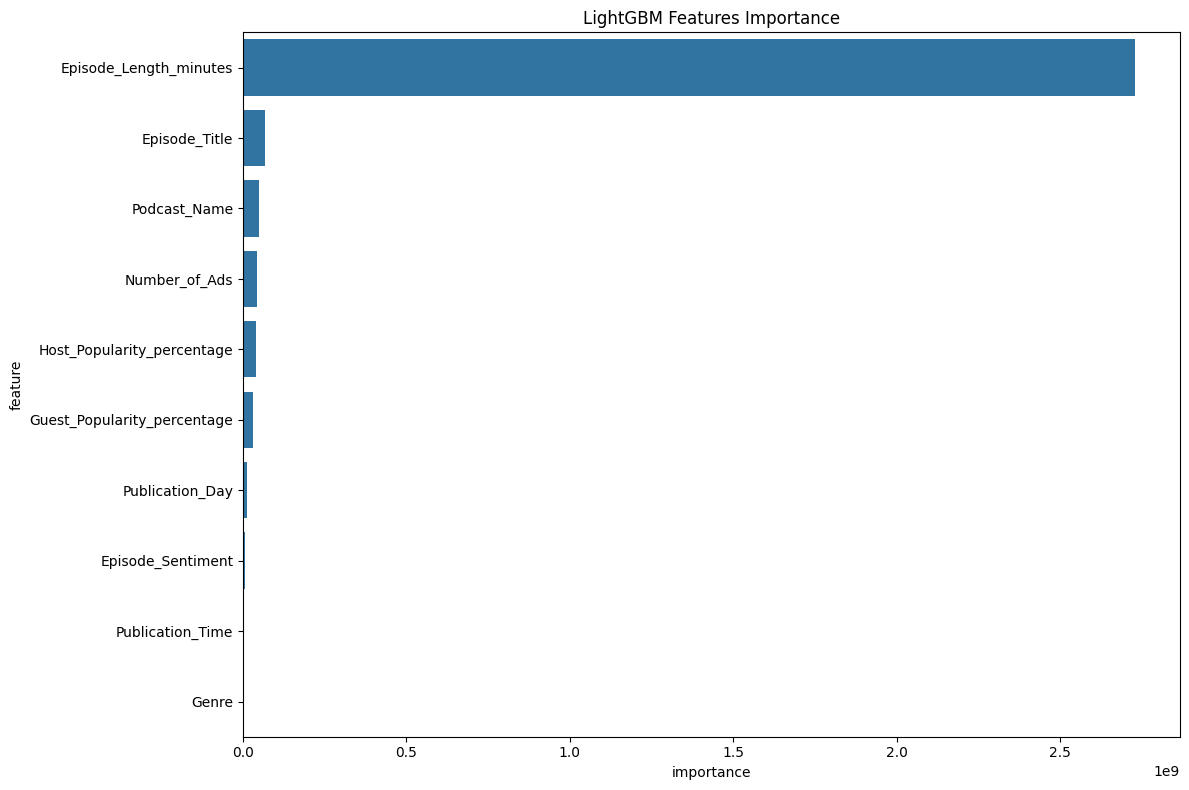

In [28]:
# Plot feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x="importance", y="feature", data=importance_df.groupby("feature").importance.mean().reset_index().sort_values("importance", ascending=False).head(20))
plt.title('LightGBM Features Importance')
plt.tight_layout()
plt.savefig('feature_importance.png')